## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from time import time, sleep
from random import choice
from pprint import pprint
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import json
import re

#### Prepare for viewing long text in CSVs

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the two data files

In [4]:
subtweets_data = [t for t in json.load(open("../data/other_data/subtweets.json")) 
                  if t["tweet_data"]["user"]["lang"] == "en" 
                  and t["reply"]["user"]["lang"] == "en" ]

In [5]:
non_subtweets_data = [t for t in json.load(open("../data/other_data/non_subtweets.json")) 
                      if t["tweet_data"]["user"]["lang"] == "en" 
                      and t["reply"]["user"]["lang"] == "en" ]

#### Find the length of the smaller dataset

In [6]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Check the lengths and see examples
#### Cut down both datasets to be the same size

In [7]:
subtweets_data = [t["tweet_data"]["full_text"] for t in subtweets_data][:smallest_length]

In [8]:
print("Subtweets dataset length: {}".format(len(subtweets_data)))

Subtweets dataset length: 8037


In [9]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
My nephew frequently places the TV remote next to me.
#whydoeshedoitlikethat


In [10]:
non_subtweets_data = [t["tweet_data"]["full_text"] for t in non_subtweets_data][:smallest_length]

In [11]:
print("Non-subtweets dataset length: {}".format(len(non_subtweets_data)))

Non-subtweets dataset length: 8037


In [12]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
Watching the CNBC @HalftimeReport it appears that balding men over 50 with god awful facial hair and ridiculous ponytails are in vogue right now. https://t.co/MOfNNAME7z


#### Prepare data for training

In [13]:
subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                   "subtweet") for tweet in subtweets_data]

In [14]:
non_subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                       "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [15]:
training_data = subtweets_data + non_subtweets_data

#### (Do not) create training and test sets from the single training set I made before

In [16]:
# text_train, text_test, class_train, class_test = train_test_split([row[0] for row in training_data], 
#                                                                   [row[1] for row in training_data], test_size=0.1)

#### Use NLTK's tokenizer instead of Scikit's

In [17]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [18]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        others = ["You", "You're", "Youre", "Your", "Yours", "U", "Ur", "Urs",
                  "She", "She's", "Shes", "Her", "Hers", 
                  "He", "He's", "Hes", "Him", "His", 
                  "They", "They're", "Theyre", "Them", "Their", "Theirs"]
        others_lower = set([other.lower() for other in others])
        
        selfs = ["I", "I'm", "Im", "We", "We're", "Our", "Ours", "My", "Mine", "Us"]
        selfs_lower = set([self.lower() for self in selfs])
        
        names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])
        
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
                
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            
            num_others = len(others_lower.intersection(tokenized_text))
            num_selfs = len(selfs_lower.intersection(tokenized_text))
            num_at_symbols = text.count("@")
            num_subtweet = text.count("subtweet") + text.count("Subtweet")
            num_urls = len(re.findall(pattern, text))
            num_names = len(names_lower.intersection(tokenized_text))
            
            weighted_dict = {"num_others": num_others,
                             "num_selfs": num_selfs,
                             "num_at_symbols": num_at_symbols,
                             "num_subtweet": num_subtweet,
                             "num_urls": num_urls, 
                             "num_names": num_names}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [19]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                         ngram_range=(1, 3), 
                                         stop_words="english")),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer())
        ]))
    ])),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [20]:
text_training_data = np.array([row[0] for row in training_data])

In [21]:
class_training_data = np.array([row[1] for row in training_data])

In [22]:
kf = KFold(n_splits=10, random_state=7, shuffle=True)

In [23]:
cnf_matrix = np.zeros((2, 2), dtype=int)
for train_index, test_index in kf.split(text_training_data):
    # print("TRAIN:", train_index, "TEST:", test_index)
    
    text_train, text_test = text_training_data[train_index], text_training_data[test_index]
    class_train, class_test = class_training_data[train_index], class_training_data[test_index]
    
    sentiment_pipeline.fit(text_train, class_train)
    predictions = sentiment_pipeline.predict(text_test)
    
    # print(predictions)
    
    cnf_matrix += confusion_matrix(class_test, predictions)
    
    print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

non-subtweet       0.74      0.77      0.75       814
    subtweet       0.75      0.72      0.74       794

 avg / total       0.75      0.75      0.74      1608

              precision    recall  f1-score   support

non-subtweet       0.74      0.74      0.74       832
    subtweet       0.73      0.73      0.73       776

 avg / total       0.74      0.74      0.74      1608

              precision    recall  f1-score   support

non-subtweet       0.72      0.72      0.72       805
    subtweet       0.72      0.71      0.72       803

 avg / total       0.72      0.72      0.72      1608

              precision    recall  f1-score   support

non-subtweet       0.71      0.72      0.72       791
    subtweet       0.73      0.72      0.72       817

 avg / total       0.72      0.72      0.72      1608

              precision    recall  f1-score   support

non-subtweet       0.71      0.76      0.74       807
    subtweet   

#### Define function for visualizing confusion matrices

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title="Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted Label")

#### Show the matrices

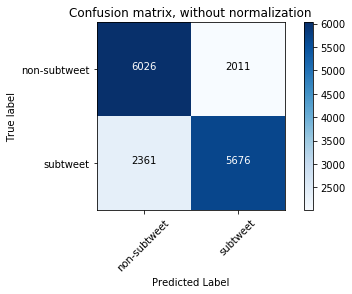

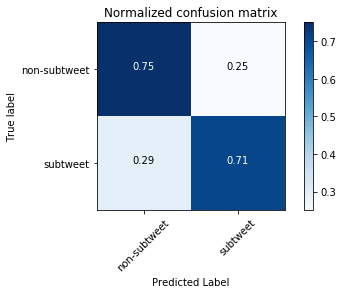

In [25]:
class_names = ["non-subtweet", "subtweet"]

# cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Update matplotlib style

In [26]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [27]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [28]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [29]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [30]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [31]:
%%time
tests_dataframe(test_tweets_df, text_column="Tweet", 
                sentiment_column="Sentiment").drop(["sentiment_score", 
                                                    "subtweet_negative_probability"], axis=1).head()

CPU times: user 16.3 ms, sys: 7.04 ms, total: 23.3 ms
Wall time: 21.7 ms


,subtweet_positive_probability,tweet
1,0.836590,Isn't it funny how some people don't know their place?
0,0.815558,Some people don't know their place.
2,0.811492,How come you people act like this?
3,0.776308,You're such a nerd.
4,0.683420,"I love Noah, he's so cool."


#### Test on actual tweets

In [32]:
naji_df = pd.read_csv("../data/data_for_testing/other_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [33]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [34]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [35]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [36]:
print("Length of dataset: {}".format(len(naji_df)))

Length of dataset: 1564156


#### (Don't) use randomly selected 5K rows from dataset

In [37]:
# naji_df = naji_df.sample(n=5000).reset_index(drop=True)

#### Print and time the tests

In [38]:
%%time
naji_df = tests_dataframe(naji_df).drop(["sentiment_score", "subtweet_negative_probability"], axis=1)

CPU times: user 5min 59s, sys: 7.1 s, total: 6min 6s
Wall time: 6min 27s


In [39]:
naji_df.to_csv("../data/data_from_testing/other_data/naji_tests.csv")

In [40]:
naji_df.head()

,subtweet_positive_probability,tweet
536480,0.953027,#haveyouever had a real life friend follow u on twitter but u blocked them cuz u don't like ppl you know following u on twitter?
636297,0.951562,"cuz when youre fifteen and somebody tells you they love you ,you're gonna believe them..."
991591,0.950898,Its funny when people say they'll be there to help if you need them yet when time comes they're not or all they do is complain about it.
1451679,0.950591,"i tweet, you tweet, we tweet, they tweet, he tweets, she tweets, EBERYBODY TWEEEETS"
1255435,0.950065,thinks people really dont understand even when their words to you say they do u think something then realise something else


#### Plot the results

In [41]:
naji_df_for_plotting = naji_df.drop(["tweet"], axis=1)

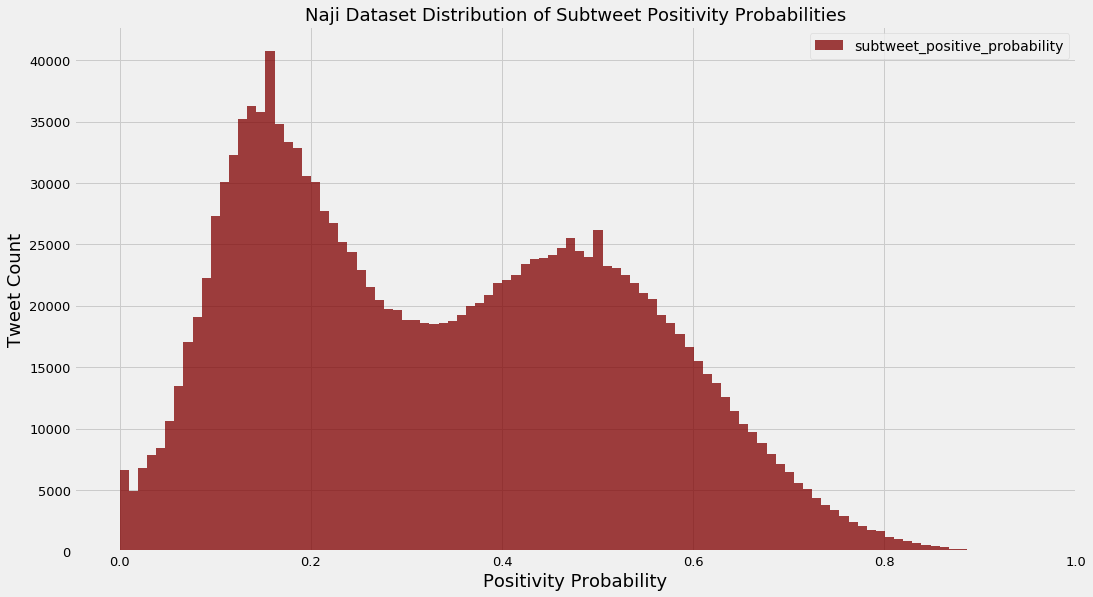

In [42]:
ax = naji_df_for_plotting.plot.hist(bins=100, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Naji Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Tests on friends' tweets

#### Aaron

In [43]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [44]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

CPU times: user 747 ms, sys: 35.5 ms, total: 783 ms
Wall time: 802 ms


In [45]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [46]:
aaron_df.head()

,subtweet_positive_probability,tweet
3284,0.959268,Also you don't need to resort to social media 24/7 to complain about your very privileged life ¯\_(ツ)_/¯
1588,0.939174,tbt to when I went to dtr and you weren't there so I got food and left but apparently you're there so ¯\_(ツ)_/¯
3299,0.935877,When I try to be supportive and caring I get ignored and then I'm told I'm not being supportive or caring ¯\_(ツ)_/¯
3218,0.933170,"""i do have aids ¯\_(ツ)_/¯. That's what happens when you're super gay"" #quotesfromwork"
3224,0.923250,When you get called a faggot ¯\_(ツ)_/¯


In [47]:
aaron_df_for_plotting = aaron_df.drop(["tweet"], axis=1)

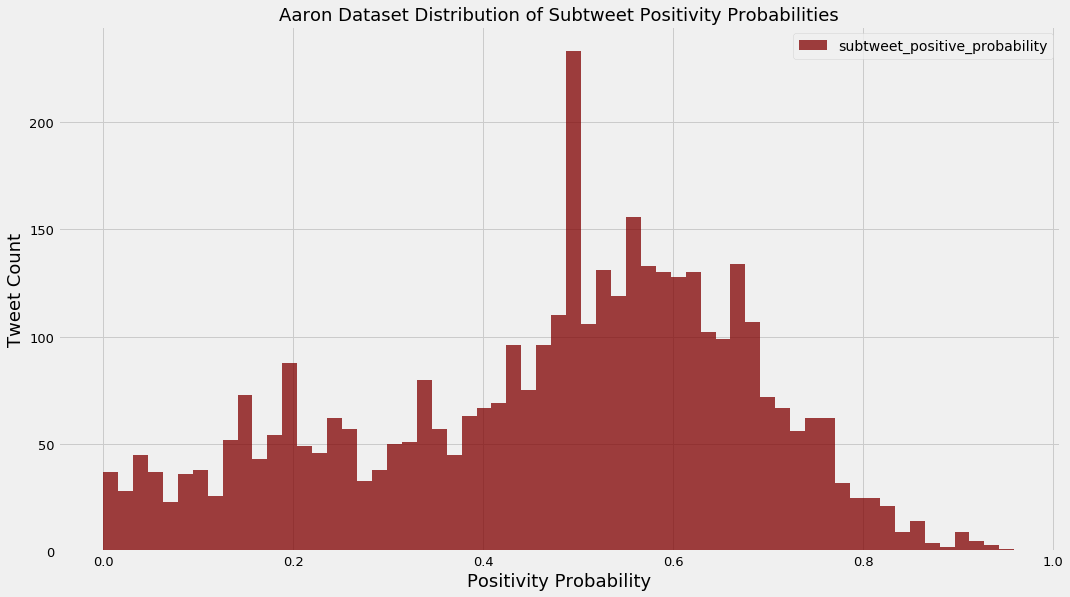

In [48]:
ax = aaron_df_for_plotting.plot.hist(bins=int(sqrt(len(aaron_df_for_plotting)-1)-1), figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Aaron Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Julia

In [49]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [50]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

CPU times: user 1.57 s, sys: 29.3 ms, total: 1.6 s
Wall time: 1.61 s


In [51]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [52]:
julia_df.head()

,subtweet_positive_probability,tweet
2926,0.928153,"if ur white and u didn't grow up saying ""y'all"" but you do now bc #trendy, consider NOT doing that"
1545,0.920710,don't teach her bitch stole your futon and has been rude to you
4197,0.913307,u kno the feel where u rly want to tweet about a part of ur life to get feelings out but u can't bc it could be regarded as a subtweet?? ya
4709,0.910289,"funny how some people have suddenly become serious """"academics"""" and think they're amazingly intelligent now....try no bitch u fake as fuck"
609,0.909872,I KNOW people LOVE THEM just give the people what they want


In [53]:
julia_df_for_plotting = julia_df.drop(["tweet"], axis=1)

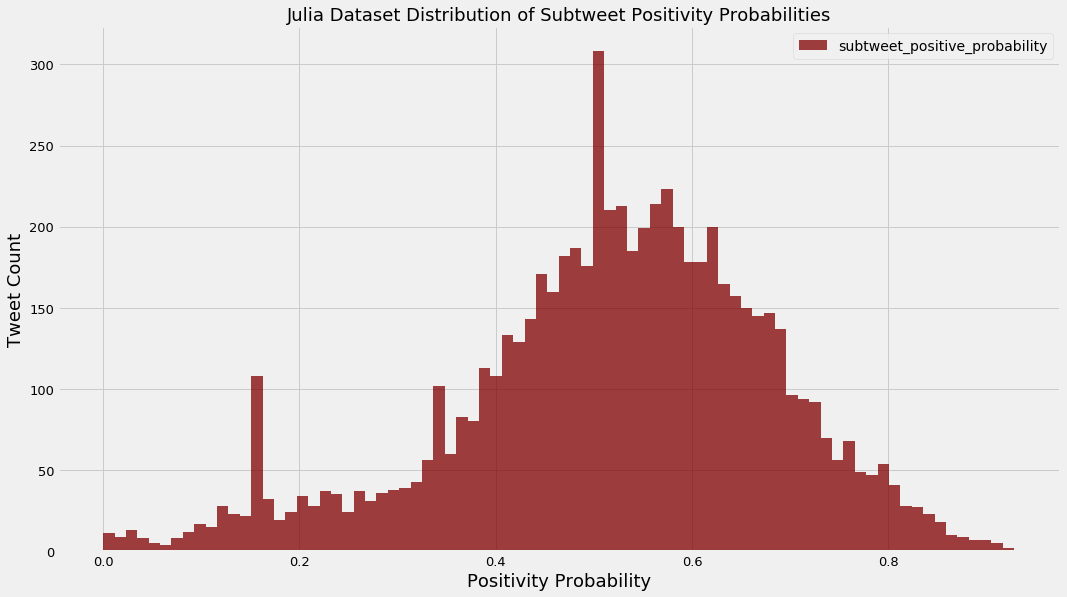

In [54]:
ax = julia_df_for_plotting.plot.hist(bins=int(sqrt(len(julia_df_for_plotting)-1)-1), figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Julia Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Zoe

In [55]:
zoe_df = pd.read_csv("../data/data_for_testing/friends_data/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [56]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", 
                         sentiment_column="Sentiment").drop(["sentiment_score",
                                                             "subtweet_negative_probability"], axis=1)

CPU times: user 264 ms, sys: 7.21 ms, total: 271 ms
Wall time: 269 ms


In [57]:
zoe_df.to_csv("../data/data_from_testing/friends_data/zoeterhune_tests.csv")

In [58]:
zoe_df.head()

,subtweet_positive_probability,tweet
583,0.900280,"and u decide to tweet about it weeks later bc no one ever talked about it and ur anxious mind decided 2 interpret that as no one caring when, in reality, it's probably people forgetting because you, and your particular brand of anxiety, bounce haphazardly from one mood 2 the ..."
791,0.895111,Delet this tweet \nWhen ur famous u don't need people seeing this
803,0.888173,the fact that twitter shows tweets people you follow have liked means that sub-liking is also a thing
1304,0.886023,maybe girls don’t “go for nice guys” bc they’re too busy going for nice girls
1296,0.885894,word to the wise don’t go thru ur snapchat memories at 3 AM after a break up


In [59]:
zoe_df_for_plotting = zoe_df.drop(["tweet"], axis=1)

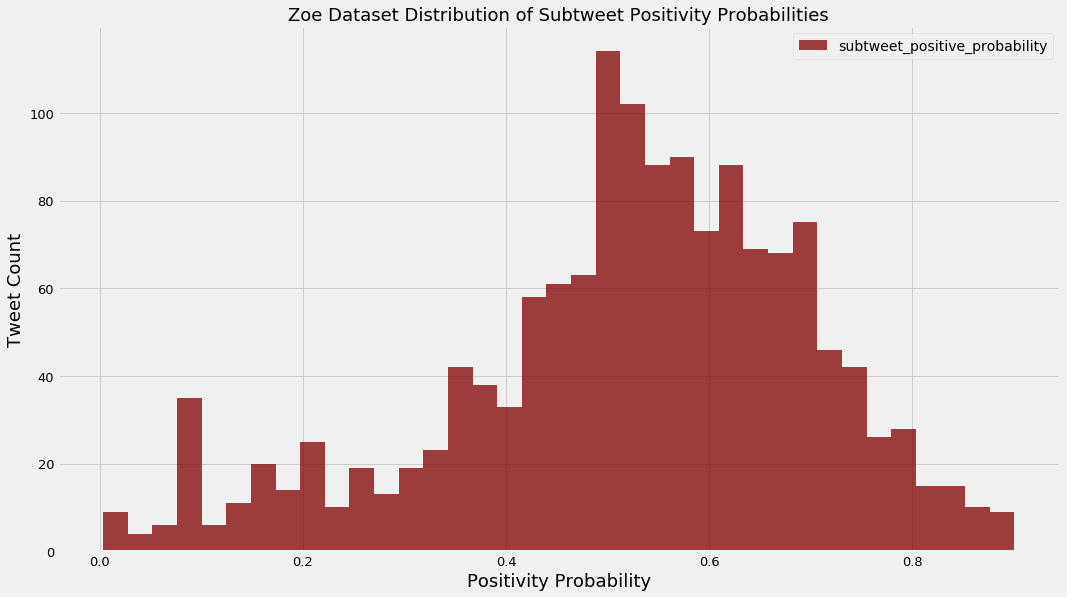

In [60]:
ax = zoe_df_for_plotting.plot.hist(bins=int(sqrt(len(zoe_df_for_plotting)-1)-1), figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Zoe Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Noah

In [61]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [62]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", 
                          sentiment_column="Sentiment").drop(["sentiment_score", 
                                                              "subtweet_negative_probability"], axis=1)

CPU times: user 919 ms, sys: 15.8 ms, total: 934 ms
Wall time: 949 ms


In [63]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [64]:
noah_df.head()

,subtweet_positive_probability,tweet
608,0.934050,If your face is symmetrical I don’t like you
992,0.932184,wow the bots really likes this tweet\nBUT YOU DONT KNOW\nWHAT THEY WENT THROUGH\nFOR HER TO OPEN UP\nAND *NOT* BE A SOCIOPATHIC MURDERER\nand I think it was only 2-3 times
3236,0.928562,you may think you're cool but unless you're friends with my friends you're not actually as cool as you could be
1225,0.918589,"Catch me, projecting my frustrations toward myself onto fictional conversations I’ve never had with people who don’t talk to me"
3766,0.916301,TFW you forget you're logged in to your twitter bot and you accidentally Tweet from it


In [65]:
noah_df_for_plotting = noah_df.drop(["tweet"], axis=1)

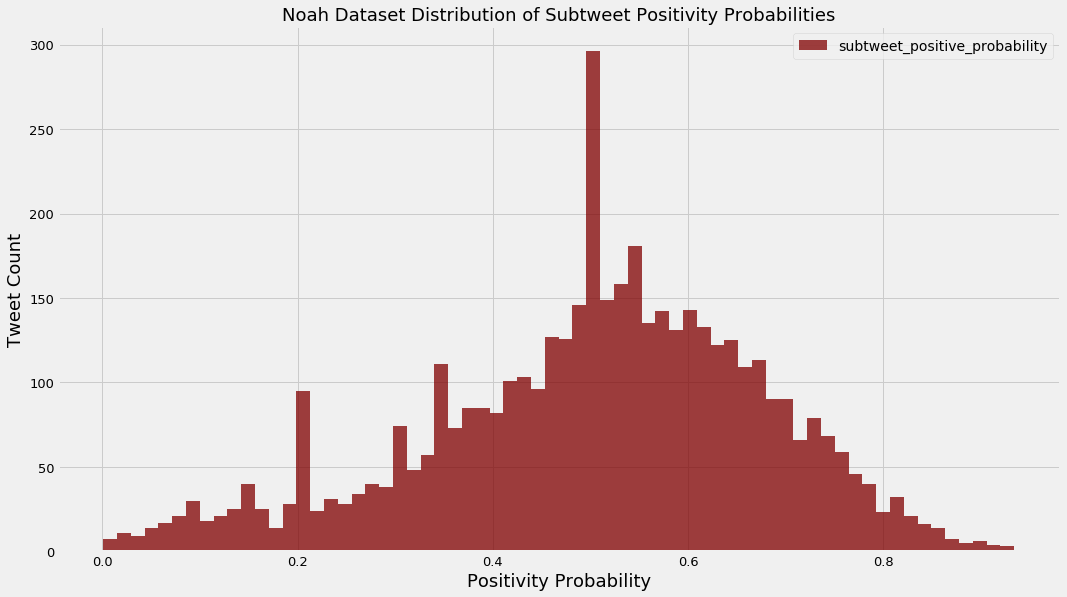

In [66]:
ax = noah_df_for_plotting.plot.hist(bins=int(sqrt(len(noah_df_for_plotting)-1)-1), figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Noah Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);